# Accelerated SGD

We can accelerate the process of stochastic gradient descent using a few tips and tricks.

In [ ]:
#| default_exp accel

In [ ]:
#| export
from __future__ import annotations
import math, random, torch, matplotlib.pyplot as plt, numpy as np
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
from functools import partial
import fastcore.all as fc

from torch import tensor, nn, optim
import torch.nn.functional as F
from datasets import load_dataset
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler

from miniai.learner import *
from miniai.datasets import *
from miniai.conv import *
from miniai.activations import *
from miniai.core import *
from miniai.initialisation import *

import re
from torcheval.metrics import MulticlassAccuracy

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

<torch._C.Generator>

In [ ]:
name = 'fashion_mnist'
ds = load_dataset(name)
bs = 1024
seed = 42

@inplace
def transform(b): b['image'] = [TF.to_tensor(o) for o in b['image']]

tds = ds.with_transform(transform)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
train, valid = dls.train, dls.valid
xb, yb = next(iter(train))
xb.shape, yb.shape

Found cached dataset fashion_mnist (/Users/olly/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

In [ ]:
#| export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
def get_model(norm=nn.BatchNorm2d, act=GeneralReLU):
    return nn.Sequential(
        ConvNormAct(1, 8, norm=norm, act=act),                 #14x14
        ConvNormAct(8, 16, norm=norm, act=act),                 #7x7
        ConvNormAct(16, 32, norm=norm, act=act),                #4x4
        ConvNormAct(32, 64, norm=norm, act=act),               #2x2
        ConvNormAct(64, 10, act=None, norm=None),
        nn.Flatten()
    ).apply(partial(kaiming_init, leak=0.1))

In [ ]:
cbs = [
    DeviceCB(), 
    MetricsCB(accuracy=MulticlassAccuracy()), 
    ProgressCB(), 
    ActivationStats(append_stats, layer_filter=fc.risinstance(nn.Conv2d)),
    BatchTransform(normalise_batch)
]

In [ ]:
model = get_model()
learn = BaseLearner(dls, model, cbs=cbs, scheduler=None)
learn.fit(0.2, 3)

   Train loss  Valid loss  Accuracy
0      0.7626      0.5452    0.8014


   Train loss  Valid loss  Accuracy
1      0.4742       0.455    0.8369


   Train loss  Valid loss  Accuracy
2      0.4189      0.4217    0.8464


To include:
    
1. Weight decay
2. Momentum
3. RMSProp
4. Adam
5. LR schedulers

## Momentum

In a traditional SGD process, the algorithm is highly responsive to the output of each batch. If the current batch has a wildly different mean or standard deviation from the previous batches, the gradient is going to be calculated according to that difference. This means that there will be a big update in the direction of the model.

However, when traversing the loss surface, we are trying to discover a minimum without getting distracted by the ups and downs. Momentum is a mechanism for biasing the model towards the information it has accumulated so far, such that it does not react as violently to batches with a wildly different mean/std. The idea is that momentum enables the model to take a much smoother path through the loss surface, where there is a 'momentum' towards the accumulated direction.

It achieves this by calculating an exponentially weighted average of the gradient at each step and storing this in a history.

To start, let's begin with the traditional SGD optimiser.

In [ ]:
class SGD:
    def __init__(self, params, lr):
        params = list(params)
        fc.store_attr()
        
    def step(self):
        with torch.no_grad():
            for p in self.params: self.opt_step(p)
            
    def opt_step(self, p): p -= p.grad * self.lr
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [ ]:
model = get_model()
learn = BaseLearner(dls, model, cbs=cbs, scheduler=None, opt_func=SGD)
learn.fit(0.4, 5)

   Train loss  Valid loss  Accuracy
0      0.7665      0.5236    0.8062


   Train loss  Valid loss  Accuracy
1       0.449      0.4455    0.8403


   Train loss  Valid loss  Accuracy
2      0.3936      0.4053    0.8516


   Train loss  Valid loss  Accuracy
3      0.3605      0.3907    0.8606


   Train loss  Valid loss  Accuracy
4      0.3388      0.3915    0.8576


To enable momentum inside the optimiser, we interpolate between the value of the accumulated gradient average and the update on the current step.

In [ ]:
class Momentum(SGD):
    def __init__(self, params, lr, mom=0.9):
        super().__init__(params, lr)
        self.mom = mom
    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = (self.mom * p.grad_avg) + ((1-self.mom) * p.grad)
        p -= p.grad_avg * self.lr

In [ ]:
model = get_model()
learn = BaseLearner(dls, model, cbs=cbs, scheduler=None, opt_func=Momentum)
learn.fit(0.4, 5)

   Train loss  Valid loss  Accuracy
0      0.7796      0.4828    0.8175


   Train loss  Valid loss  Accuracy
1      0.4198      0.4185    0.8451


   Train loss  Valid loss  Accuracy
2      0.3686      0.3878    0.8578


   Train loss  Valid loss  Accuracy
3       0.339      0.3695    0.8644


   Train loss  Valid loss  Accuracy
4      0.3182      0.3559    0.8703


We can see that this trains more quickly. Why is this? Well, we can illustrate it with a simple example.

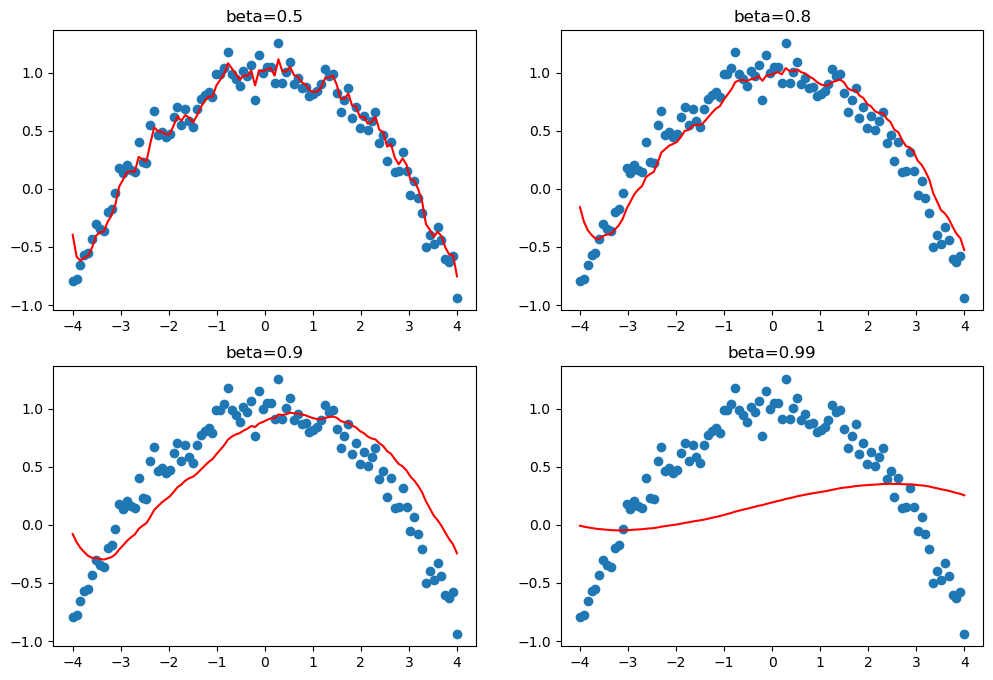

In [ ]:
x = torch.linspace(-4, 4, 100)
y = 1 - (x/3)**2 + torch.randn(100)*0.1

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
betas = [0.5, 0.8, 0.9, 0.99]
for beta, ax in zip(betas, axs.flatten()):
    ax.scatter(x, y)
    avg, res = 0,[]
    for yi in y:
        avg = beta*avg + (1-beta)*yi
        res.append(avg)
    ax.plot(x, np.array(res), color='red')
    ax.set_title(f'beta={beta}')

As we increase the beta value (the extent to which we bias towards the accumulated gradient average), the algorithm becomes less reactive to the current batch of data. It can follow the general trend, but it does not get distracted by the outliers. However, note that if we increase the momentum too far, then the algorithm no longer reacts at all the current batch of data.

## RMSProp

Momentum is a useful addition that helps networks to train more quickly. However, it is quite a strong measure that can impact the ability of a model to respond to changes. This is particularly true in sensitive architectures.

RMSProp takes a similar approach. But rather than maintaining a gradient average, it maintains a *square* average of the gradient and interpolates between this value and the current update. And rather than just multiplying this term by the learning rate, it instead divides the gradient by the square root of the square average. This way, the algorithm biases towards the *confidence* of the current direction.

When using a square term, negatives are cancelled and high square averages will indicate high variance, assuming that activations are normally distributed around a mean of 0. The gradient is divided by the root of the square average in each batch, which penalises the gradient by the size of the standard deviation — in cases where the standard deviation is low, we make larger updates because the divisor is small (and the gradient remains roughly as it was). In cases where the standard deviation is high, we make smaller updates because the divisor is high.

In [ ]:
class RMSProp(SGD):
    def __init__(self, params, lr, sqr_mom=0.99, epsilon=1e-5):
        super().__init__(params, lr)
        self.sqr_mom, self.epsilon = sqr_mom, epsilon
    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
        p.sqr_avg = (self.sqr_mom * p.sqr_avg) + ((1-self.sqr_mom) * (p.grad**2))
        p -= self.lr * p.grad / (p.sqr_avg.sqrt() + self.epsilon)

In [ ]:
model = get_model()
learn = BaseLearner(dls, model, cbs=cbs, scheduler=None, opt_func=RMSProp)
learn.fit(0.01, 5)

   Train loss  Valid loss  Accuracy
0      0.7649      0.4812    0.8174


   Train loss  Valid loss  Accuracy
1      0.4069      0.3919    0.8527


   Train loss  Valid loss  Accuracy
2      0.3534      0.3747    0.8598


   Train loss  Valid loss  Accuracy
3      0.3231      0.3534    0.8693


   Train loss  Valid loss  Accuracy
4      0.3004      0.3656    0.8659


## Weight decay

Networks tend to work best when the weights are small. This is because large weights cause a bumpier loss surface. Consider a simple parabola in which we increase the value of the coefficient — the shape of the parabola becomes narrower. We can imagine something similar in the high dimensional space of the loss surface, in which large weights cause the calculation of large deltas between gradients, leading to a very bumpy surface.

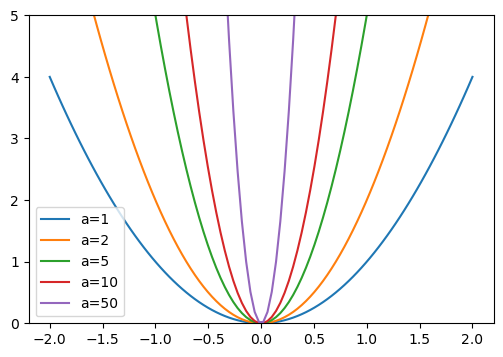

In [ ]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(6,4))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

Weight decay aims to overcome this problem by encouraging the weights to remain small throughout the training process. It involves adding on a contribution proportional to the size of the weights.

    loss_with_wd = loss + wd * (parameters**2).sum()
    
As the weights get larger, the loss will increase. As such, the network will learn to keep the weights low as this will minimise the calculation of the loss term. However, it's not tractable to calculate the sum of all parameters squared, since this would be an arbitrarily large number. Ultimately, since the loss backpropagates as the *derivative* of the loss, we are only really interested in finding the derivative of the loss with weight decay. As such, we can calculate the loss and then add on the weight decay inside the derivative. Since the parameter term is squared, its derivative will be 2x. And this 2 can be absorbed into the weight decay term simply by doubling it.

    parameters.grad += wd * 2 * parameters
    parameters.grad += wd * parameters

In [ ]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        
    def step(self):
        with torch.no_grad():
            for p in self.params: 
                self.reg_step(p)
                self.opt_step(p)
    
    def reg_step(self, p): p.grad += self.wd*p
    def opt_step(self, p): p -= p.grad * self.lr
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [ ]:
model = get_model()
learn = BaseLearner(dls, model, cbs=cbs, scheduler=None, opt_func=partial(SGD, wd=0.01))
learn.fit(0.01, 5)

   Train loss  Valid loss  Accuracy
0      1.8656      1.4895    0.5712


   Train loss  Valid loss  Accuracy
1      1.2964      1.1521    0.6664


   Train loss  Valid loss  Accuracy
2      1.0537      0.9852     0.699


   Train loss  Valid loss  Accuracy
3      0.9249      0.8889    0.7179


   Train loss  Valid loss  Accuracy
4      0.8456      0.8257    0.7285


## Adam

Adam is a combination of both RMSProp and Momentum. The idea is that momentum helps to keep the algorithm moving in an accumulated direction, while RMSProp helps to determine whether or not its the right direction.

In [ ]:
class Adam(SGD):
    def __init__(self, params, lr, beta1=0.9, beta2=0.999, epsilon=1e-5, wd=0.):
        super().__init__(params, lr, wd)
        self.beta1, self.beta2, self.epsilon, self.i = beta1, beta2, epsilon, 0
        
    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = (self.beta1 * p.avg) + ((1-self.beta1) * p.grad)
        p.sqr_avg = (self.beta2 * p.sqr_avg) + ((1-self.beta2) * p.grad**2)
        unbiased_avg = p.avg / (1 - (self.beta1**(self.i+1)))
        unbiased_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= (self.lr * unbiased_avg) / (unbiased_sqr_avg + self.epsilon).sqrt()
        self.i += 1

In [ ]:
model = get_model()
learn = BaseLearner(dls, model, cbs=cbs, scheduler=None, opt_func=partial(Adam, wd=0.1))
learn.fit(0.01, 5)

   Train loss  Valid loss  Accuracy
0      0.5866      0.3994    0.8511


   Train loss  Valid loss  Accuracy
1      0.3474       0.357     0.866


   Train loss  Valid loss  Accuracy
2      0.3068        0.33    0.8784


   Train loss  Valid loss  Accuracy
3      0.2816      0.3173    0.8815


   Train loss  Valid loss  Accuracy
4      0.2626      0.3126    0.8854


In [ ]:
model = get_model()
learn = BaseLearner(dls, model, cbs=cbs, scheduler=None, opt_func=optim.Adam)
learn.fit(0.01, 5)

   Train loss  Valid loss  Accuracy
0      0.5617      0.3975    0.8543


   Train loss  Valid loss  Accuracy
1      0.3439      0.3498    0.8732


   Train loss  Valid loss  Accuracy
2      0.2974      0.3313    0.8766


   Train loss  Valid loss  Accuracy
3       0.271      0.3162    0.8851


   Train loss  Valid loss  Accuracy
4      0.2515      0.3126    0.8882


## AdamW

Note that in the Pytorch API, there are two versions of Adam available — AdamW and Adam. While Adam had a lot of support when it was first released, that enthusiasm cooled as several research papers showed its inability to compete with vanilla SGD with momentum. The problem with Adam is the way in which weight decay is carried out. L2 regularisation is the process of doing this equation:

    loss_with_wd = loss + wd * (parameters**2).sum()

Which is derived as this equation:

    parameters.grad += wd * parameters
    
However, the regularisation step is carried out before the optimisation step, in order to introduce the penalty before the gradients are calculated. The Adam optimiser changes the way that the gradient is calculated, by introducing the exponentially weighted averages. Therefore, the derivative here is no longer equivalent.

Instead, what we want is to isolate the regularisation step from the parameters themselves. This way, we don't mess with the gradients in the regularisation step, we just update the parameter itself. To do so, we can use the following formula:

    parameter *= 1 - lr*wd

In [ ]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        
    def step(self):
        with torch.no_grad():
            for p in self.params: 
                self.reg_step(p)
                self.opt_step(p)
    
    def reg_step(self, p): 
        if self.wd !=0: p *= 1 - self.lr*self.wd
    def opt_step(self, p): p -= p.grad * self.lr
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [ ]:
model = get_model()
learn = BaseLearner(dls, model, cbs=cbs, scheduler=None, opt_func=partial(Adam, wd=0.1))
learn.fit(0.01, 5)

   Train loss  Valid loss  Accuracy
0       0.593      0.4303    0.8366


   Train loss  Valid loss  Accuracy
1      0.3461      0.3703    0.8615


   Train loss  Valid loss  Accuracy
2      0.3062      0.3358    0.8743


   Train loss  Valid loss  Accuracy
3      0.2859      0.3219    0.8806


   Train loss  Valid loss  Accuracy
4      0.2682      0.3129    0.8825


In [ ]:
model = get_model()
learn = BaseLearner(dls, model, cbs=cbs, scheduler=None, opt_func=partial(optim.AdamW, weight_decay=0.1))
learn.fit(0.01, 5)

   Train loss  Valid loss  Accuracy
0      0.5796      0.4013    0.8562


   Train loss  Valid loss  Accuracy
1       0.348      0.3503     0.874


   Train loss  Valid loss  Accuracy
2      0.2987      0.3273    0.8826


   Train loss  Valid loss  Accuracy
3      0.2696      0.3174     0.886


   Train loss  Valid loss  Accuracy
4      0.2515      0.3085    0.8894


## Schedulers

When you train models, you tend to find that the model benefits from a high learning rate at first. However, after a while, it finds a good bit of territory on the loss surface and a lower learning rate helps it to find the local optimum in that territory — big steps to the right area, followed by little steps to the bottom. It's a pain to do this manually, however, and a learning rate scheduler can enable you to do this automatically. There are a few different schedules that you could follow — two of the most popular ones include cosine annealing and the 1cycle policy.

In [ ]:
#| export
class LRScheduler(Callback):
    order = ProgressCB.order + 2
    def __init__(self, sched): 
        super().__init__()
        self.sched = sched
    def before_fit(self): 
        self.schedo = self.sched(self.learn.opt)
    def after_batch(self): 
        if self.learn.model.training: self.schedo.step()

### Cosine annealing

Cosine annealing decays the learning rate on a cosine curve across the epoch schedule from a maximum learning rate down to a minimum, usually a very small number. We can see this behaviour plotted on a curve:

/Users/olly/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:807: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/Users/olly/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[<matplotlib.lines.Line2D>]

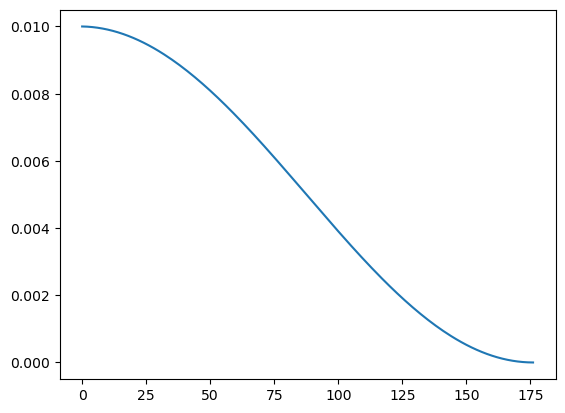

In [ ]:
sched = lr_scheduler.CosineAnnealingLR(learn.opt, 3*len(learn.dls.train))
lr_lst = []
for i in range(3*len(learn.dls.train)):
    lr_lst.append(sched.get_lr())
    sched.step()
plt.plot(lr_lst)

We can rebuild this class by modifying the state dictionary inside the optimiser object. Note that the variables of the optimiser are stored in a dictionary called a parameter group. All we need to do to update the learning rate is to update this value.

In [ ]:
learn.opt, {'lr': learn.opt.param_groups[0]['lr']}

(AdamW (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     eps: 1e-08
     foreach: None
     initial_lr: 0.01
     lr: 0.0
     maximize: False
     weight_decay: 0.1
 ),
 {'lr': 0.0})

In [ ]:
#| export
class SingleBatch(Callback):
    def __init__(self): super().__init__()
    def after_batch(self): raise CancelFitException()

In [ ]:
class CosineAnnealingLR:
    def __init__(self, optimiser, total_steps):
        super().__init__()
        self.optimiser = optimiser
        self.max_lr, self.min_lr = self.optimiser.param_groups[0]['lr'], 0
        self.current_step, self.total_steps = 0, total_steps
    def step(self):
        for group in self.optimiser.param_groups:
            group['lr'] = self.get_lr()
        self.current_step += 1
    def get_lr(self):
        if self.current_step == 0:
            return self.max_lr
        if self.current_step >= 1:
            return self.min_lr + (0.5*(self.max_lr-self.min_lr) * (1 + math.cos((self.current_step / self.total_steps) * math.pi)))

In [ ]:
# steps = 5 * len(dls.train)
# scheduler = LRScheduler(partial(CosineAnnealingLR, total_steps=steps))
# model = get_model()
# learn = BaseLearner(dls, model, cbs=cbs, scheduler=scheduler, opt_func=partial(optim.AdamW, weight_decay=0.1))
# learn.fit(0.01, 5)

   Train loss  Valid loss  Accuracy
0      0.5376      0.3786    0.8639


   Train loss  Valid loss  Accuracy
1      0.3326       0.334    0.8796


   Train loss  Valid loss  Accuracy
2      0.2889      0.3153    0.8883


   Train loss  Valid loss  Accuracy
3      0.2671      0.3063    0.8898


   Train loss  Valid loss  Accuracy
4      0.2513      0.2997    0.8921


In [ ]:
# steps = 5 * len(dls.train)
# scheduler = LRScheduler(partial(lr_scheduler.CosineAnnealingLR, T_max=steps))
# model = get_model()
# learn = BaseLearner(dls, model, cbs=cbs, scheduler=scheduler, opt_func=partial(optim.AdamW, weight_decay=0.1))
# learn.fit(0.01, 5)

   Train loss  Valid loss  Accuracy
0      0.5781      0.4054    0.8551


   Train loss  Valid loss  Accuracy
1      0.3487      0.3578     0.871


   Train loss  Valid loss  Accuracy
2      0.3012      0.3262    0.8831


   Train loss  Valid loss  Accuracy
3      0.2748      0.3154    0.8845


   Train loss  Valid loss  Accuracy
4      0.2563      0.3038    0.8898


### 1Cycle policy

Cosine annealing accounts for a reduced learning rate towards the end of training. However, when models are not perfectly initialised, it is likely that the first few steps will be suboptimal before the weights have had the chance to reach a reasonable level. To account for this, the 1Cycle policy includes a warmup schedule, in which the learning rate is increased from a initial value to a maximum value, followed by cosine annealing down to a level significantly lower than the initial value.

Aside from the learning rate, the 1Cycle policy also cycles the momentum. The theory is that when the learning rate is low, i.e. at the beginning and end of the cycle, we should be less fervent about taking a step in that direction. When the learning rate is high, however, we want to take bigger steps. So, the momentum value is cycled such that when the learning rate is high, the momentum biases the update more towards the gradient of the current step. 

Typical values for cycling are a max of 0.9 and a min of 0.85. We can see the behaviour illustrated here:

/Users/olly/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:1679: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/Users/olly/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


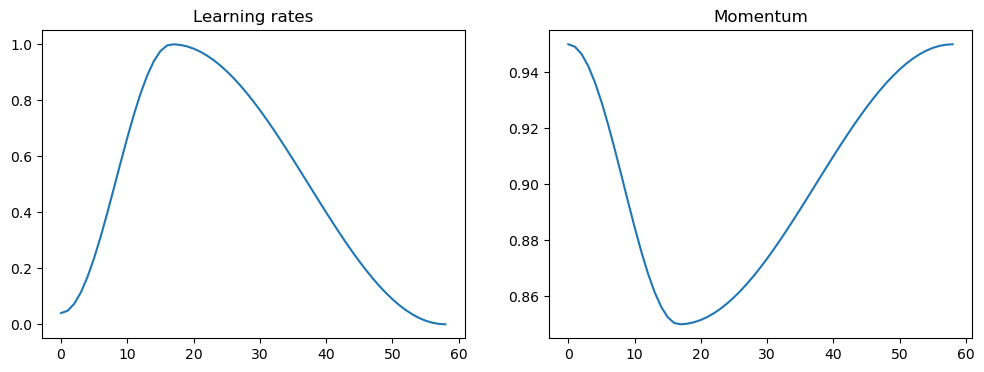

In [ ]:
sched = lr_scheduler.OneCycleLR(learn.opt, 1, epochs=1, steps_per_epoch=len(learn.dls.train))
lr_lst, mom_lst = [], []
for i in range(len(learn.dls.train)):
    lr_lst.append(sched.get_lr())
    mom_lst.append( learn.opt.param_groups[0]['betas'][0] )
    sched.step()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for i in 0,1:
    ax[i].plot(lr_lst if i == 0 else mom_lst)
    ax[i].set_title("Learning rates" if i == 0 else "Momentum")

Test code:

[<matplotlib.lines.Line2D>]

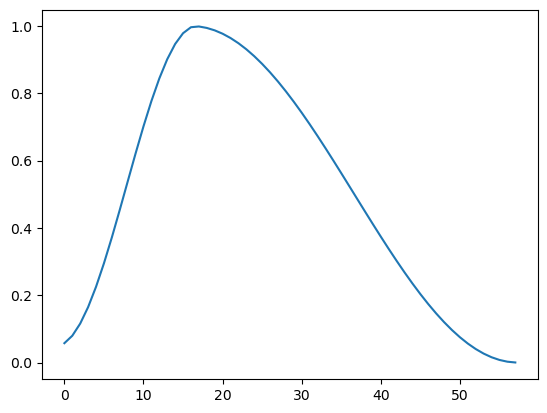

In [ ]:
eta_initial = 0.05
eta_max = 1
phase_ratio = 0.3
eta_end = eta_initial / 1e4
T_max = len(learn.dls.train)

lrs = []
for i in range(1, T_max):
    if i <= int(T_max*phase_ratio):
        lrs.append(eta_max + (0.5*(eta_initial-eta_max) * (1 + math.cos((i / (T_max*phase_ratio)) * math.pi))))
    else:
        lrs.append(eta_end + (0.5*(eta_max-eta_end) * (1 + math.cos(((i-int(T_max*phase_ratio)) / (T_max*(1-phase_ratio))) * math.pi))))
plt.plot(lrs)

In [ ]:
class OneCycle:
    def __init__(self, optimiser, total_steps, max_mom=0.95, min_mom=0.85, phase_ratio=0.3, div=25, final_div=1e4):
        fc.store_attr()
        self.max_lr = self.optimiser.param_groups[0]['lr']
        self.initial_lr = self.max_lr / div
        self.end_lr = self.initial_lr / final_div
        self.current_step = 0
    
    def step(self):
        for group in self.optimiser.param_groups:
            beta1, beta2 = group['betas']
            group['lr'] = self.get_lr()
            group['betas'] = (self.get_mom(), beta2)
        self.current_step += 1
    
    def get_mom(self):
        if self.current_step <= int(self.total_steps*self.phase_ratio):
            mmin, mmax, tm, it, pr = self.min_mom, self.max_mom, self.total_steps, self.current_step, self.phase_ratio
            return mmin + (0.5*(mmax-mmin) * (1 + math.cos((it / (tm*pr)) * math.pi)))
        else:
            mmin, mmax, tm, it, pr = self.min_mom, self.max_mom, self.total_steps, self.current_step, self.phase_ratio
            return mmax + (0.5*(mmin-mmax) * (1 + math.cos(((it-int(tm*pr)) / (tm*(1-pr))) * math.pi)))
    
    def get_lr(self):
        if self.current_step <= int(self.total_steps*self.phase_ratio):
            ei, em, ef, tm, it, pr = self.initial_lr, self.max_lr, self.end_lr, self.total_steps, self.current_step, self.phase_ratio
            return em + (0.5*(ei-em) * (1 + math.cos((it / (tm*pr)) * math.pi)))
        else:
            ei, em, ef, tm, it, pr = self.initial_lr, self.max_lr, self.end_lr, self.total_steps, self.current_step, self.phase_ratio
            return ef + (0.5*(em-ef) * (1 + math.cos(((it-int(tm*pr)) / (tm*(1-pr))) * math.pi)))

In [ ]:
# set_seed(42)
# steps = 5 * len(dls.train)
# model = get_model()
# learn = BaseLearner(dls, model, cbs=cbs, scheduler=None, opt_func=partial(optim.AdamW, weight_decay=0.1))
# learn.fit(0.01, 5)

In [ ]:
# set_seed(42)
# steps = 5 * len(dls.train)
# scheduler = LRScheduler(partial(OneCycle, total_steps=steps))
# model = get_model()
# learn = BaseLearner(dls, model, cbs=cbs, scheduler=scheduler, opt_func=partial(optim.AdamW, weight_decay=0.1))
# learn.fit(0.01, 5)

In [ ]:
# set_seed(42)
# steps = 5 * len(dls.train)
# lr, epochs = 0.2, 5
# scheduler = LRScheduler(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=steps))
# model = get_model()
# learn = BaseLearner(dls, model, cbs=cbs, scheduler=scheduler, opt_func=partial(optim.AdamW, weight_decay=0.1))
# learn.fit(lr, epochs)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()